<h1>Example: Heisenberg Model</h1>
<hr>
DISTRIBUTION STATEMENT A. Approved for public release. Distribution is unlimited.

This material is based upon work supported by the Under Secretary of Defense for
Research and Engineering under Air Force Contract No. FA8702-15-D-0001. Any opinions,
findings, conclusions or recommendations expressed in this material are those of the
author(s) and do not necessarily reflect the views of the Under Secretary of Defense
for Research and Engineering.

© 2023 Massachusetts Institute of Technology.

The software/firmware is provided to you on an As-Is basis

Delivered to the U.S. Government with Unlimited Rights, as defined in DFARS Part
252.227-7013 or 7014 (Feb 2014). Notwithstanding any copyright notice, U.S. Government
rights in this work are defined by DFARS 252.227-7013 or DFARS 252.227-7014 as detailed
above. Use of this work other than as specifically authorized by the U.S. Government
may violate any copyrights that exist in this work.

In [1]:

###
### General imports
###

#import time

import numpy              as np
import numpy.linalg       as la
import scipy.integrate    as spi
import matplotlib.pyplot  as plt


###
### Operator simulation & Hamiltonian
### preperation imports
###

import pyLIQTR.sim_methods.quantum_ops        as     qops    


###
### Imports to support the pyQSP Gate-Based simulation
###

import cirq

from pyLIQTR.QSP          import gen_qsp   as   qspFuncs
from pyLIQTR.QSP          import QSP       as   pQSP
from pyLIQTR.QSP.gen_qsp  import QSP_Simulator

from pyLIQTR.QSP.Hamiltonian import Hamiltonian as pyH
from pyLIQTR.QSP.qsp_helpers import get_state_vector
from pyLIQTR.QSP.qsp_helpers import qsp_decompose_once 

from cirq.contrib.svg import SVGCircuit




<hr>
<h2><u>Heisenberg Model</u></h2>
<b><i>Generating a Hamiltonian Matrix</i></b>
The previous tutorial demonstrated how we can use pyLIQTR to generate a Hamiltonian in matrix form and as Pauli Strings for a 1D Heisenberg model. We do so again in the following cell for an $N = 3$ site homogeneous XXZ model, just outside of the XY to ferromagnetic transition ($J^z = 1.0$, $J^x = J^y = 1.1 \cdot J^z$). We also include a $h^x$ term to drive some interesting dynamics.

This is simply an example, and one can consult Tutorial_1a/b to better understand the physical model at play.

In [2]:
#Physical problem specification
N    =    3;       

J_z  =    1.0;

J_x  =    1.1*J_z;     J_y  =   J_x;               
h_x  =   -1.0*J_z;     h_y  =   0.0*J_z;     h_z  =   0.0*J_z;

#pyLIQTR utilities

tuples,types,coeffs = qops.params_heisenberg_1d(N,
                                                J_x=J_x,J_y=J_y,J_z=J_z,
                                                h_x=h_x,h_y=h_y,h_z=h_z,
                                                periodic=False)

ham_strings = qops.ps_text_full_set(tuples,types,N,Coeffs=coeffs)
H = qops.ham_from_pauli_tuples(tuples,types,coeffs,N)


<h3>Classical Simulation</h3>


Although our goal is to generate circuits for quantum simulation, it is helpful to have some classical reference values on hand as a sanity check.  To this end, we can use the Hamitonian matrix $H$ that was generated by `ham_from_pauli_tuples` to numerically integrate the Heisenberg model following a field quench.  We begin by setting some initial parameters:

In [3]:
dt            =  0.2                             # Integration timestep, Decrease this 
                                                 #   if you'd like a finer grain simulation
tmax          =  2.0                             # Maximal timestep
sclf          =  1                               # Scale factor for timestep sampling
N_ts          =  int(np.ceil(tmax/dt))           # Total number of timesteps
timestep_vec  =  np.arange(0,tmax+dt,sclf*dt)    # Define array of timesteps


Next, we build up the initial wavefunction as a spin-up product state $\mid\psi_0\rangle = \bigotimes_{j=0}^{N-1} \mid \uparrow\rangle$ so that:

In [4]:

psi0 = qops.multikron([qops.sz_u]*N)             # Generate the wavefunction as a 
psi0 = psi0 / la.norm(psi0)                      # Kronecker product and normalize it.

psi0_vec = qops.vectorize_cvec(psi0)             # Vectorize the initial wavefunction


The following cell executes the classical simulation, and generates a plot of an observable of interest. The result of the QSP circuit simulation should look similar.


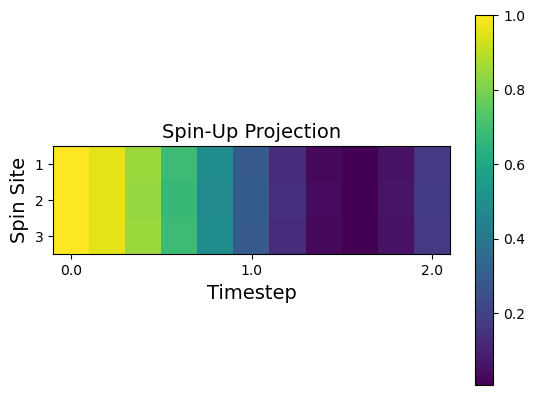

In [5]:
traj_raw_wfn = spi.odeint(qops.prop_wfn,psi0_vec,timestep_vec,args=(H,),atol=1e-16)


traj_proc_wfn = qops.parse_wfn_traj(timestep_vec,traj_raw_wfn,qops.przp)

obs_reference = traj_proc_wfn[:,1:(N+1)].real

N_ticks = 2

#aspect = 1/0.05
aspect  = 1.0

plt.imshow(np.transpose(obs_reference),
           cmap='viridis', interpolation='nearest', aspect=aspect)
plt.xlabel('Timestep',fontsize=14)
plt.ylabel('Spin Site',fontsize=14)
plt.title('Spin-Up Projection',fontsize=14)

plt.yticks(range(0,N),range(1,N+1))
plt.xticks(np.arange(0,N_ts+1,N_ts/N_ticks),labels=np.arange(0,tmax+dt,int(tmax/N_ticks)))

plt.colorbar()

plt.show()



<h3>QSP: Circuit Generation</h3>

In the previous tutorial we having convinced ourselves that QSP is giving a numerically sensible result, so we can procede to construct practical circuits for quantum simulation.   Circuit generation is performed by the `pQSP` class from the   `pyLIQTR` library.  Once again, we require an input set of tuples that contain Pauli strings for the target Hamiltonian and their corresponding coefficients.  We previously generated these using the `ps_text_full_set(...)` routine, and we replicate this step here for completeness:

In [6]:

sclf  =  np.sum(np.abs(coeffs))

ham_strings = qops.ps_text_full_set(tuples,types,N,Coeffs=coeffs / sclf)
ham_strings


[('XXI', 0.11702127659574468),
 ('IXX', 0.11702127659574468),
 ('YYI', 0.11702127659574468),
 ('IYY', 0.11702127659574468),
 ('ZZI', 0.10638297872340426),
 ('IZZ', 0.10638297872340426),
 ('XII', -0.10638297872340426),
 ('IXI', -0.10638297872340426),
 ('IIX', -0.10638297872340426)]

To begin, let's generate a QSP sequence for a single timestep ($t_\text{max} = \delta t$).  In this case, an internal representation of the target Hamiltonian is generated from Pauli strings using the `pyH(...)` routine:

In [7]:

qsp_H       = pyH(ham_strings)


Which we can then pass as an argument to a separate set of angle generation routines (<b>NOTE: We continue to use this legacy implementation, though it will soon be deprecated in favor of the new more flexible and portable angle generation implementation </b>):

In [8]:

required_precision = 1e-2

#Old, deprecated call:
#angles, tolerances = qspFuncs.get_phis(qsp_H, simtime=dt*sclf, 
#                                       req_prec=required_precision);
angles, tolerances = qspFuncs.compute_hamiltonian_angles(qsp_H,simtime=dt*sclf, req_prec=required_precision,\
                                        mode="legacy")

[14:03:54]  ~ minimum error (empirical): 0.0002348147409440639
[14:03:54] 1 cached results with tau=1.88, m=12: prec=456
[14:03:54] retrieved cached angles from /Users/ju30831/opt/anaconda3/envs/quantum_algorithms-main/lib/python3.8/site-packages/pyLIQTR-0.2.0-py3.8.egg/pyLIQTR/QSP/.qspangles.cache


Req eps = 0.01	Act eps = 0.000234814740944064


With the required phase angles and Hamiltonian in hand, we use the `QSP` class (imported here as `pQSP`) to construct the target circuit:

In [9]:

qsp_generator = pQSP.QSP(phis=angles, hamiltonian=qsp_H, 
                         target_size=qsp_H.problem_size)

qsp_circ      = qsp_generator.circuit()


The output `qsp_circ` is a standard `cirq` circuit.  we can print this to see a high-level organization of the QSP sequence:

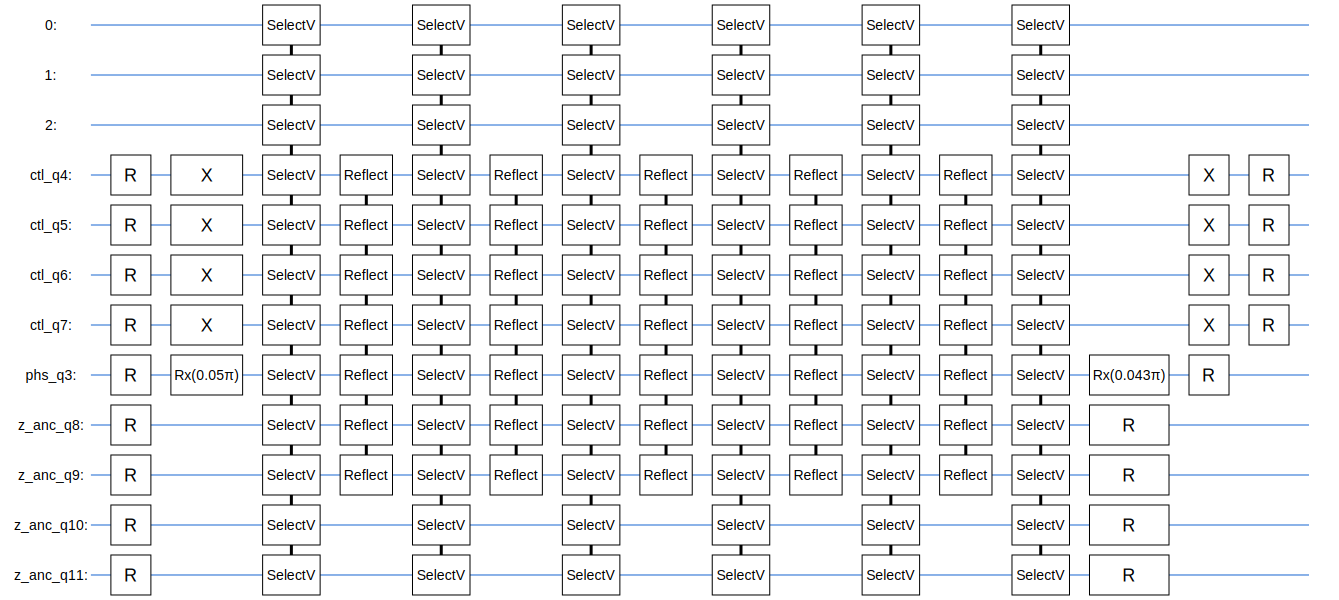

In [10]:
qsp_circ
SVGCircuit(qsp_circ)

Or decompose the circuit to see constituents of the `SelectV` and `Reflect` unitaries.

The following cell shows how these unitaries are further broken down into `SelectVBase`, `Prepare` and a `MultiCZ` operators of QSP, alongsite rotation gates that apply the rotation prescribed by the angle calculation.

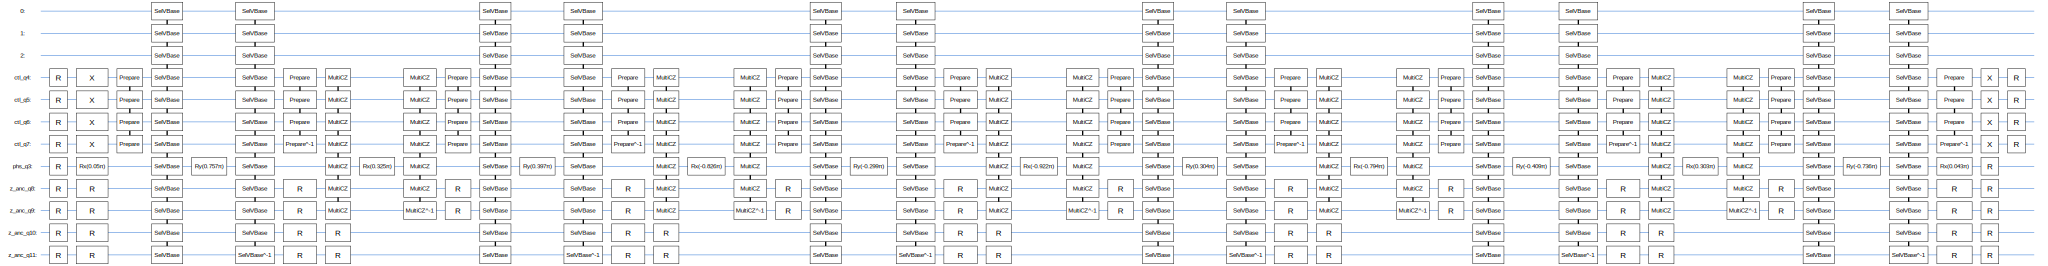

In [11]:
decomposed_once_circuit = cirq.align_left((qsp_decompose_once(qsp_circ)))
SVGCircuit(decomposed_once_circuit)

We can then further decompose the operators into single qubit and two qubit gate representations of the above operators (we note, that this is not a unique construction for the above operators, but these are fairly efficient ones).

In [12]:
decomposed_circuit      = cirq.align_left((qsp_decompose_once(decomposed_once_circuit)))
SVGCircuit(decomposed_circuit)


<h3>QSP: Circuit Simulation</h3>
We just saw how to construct a circuit for a single timestep.  This can be extended to generate its multi-timestep counterpart, which is straightforward to  simulate using `cirq`.  The first step is to generate angles for each timestep of interest.

For comparative purposes, the classically computed result on this domain is:

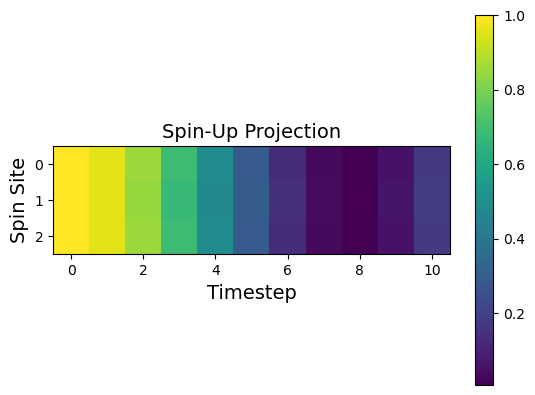

In [13]:
aspect  = 1.0

plt.imshow(np.transpose(obs_reference),
           cmap='viridis', interpolation='nearest', aspect=aspect)
plt.xlabel('Timestep',fontsize=14)
plt.ylabel('Spin Site',fontsize=14)
plt.title('Spin-Up Projection',fontsize=14)

plt.colorbar()

plt.show()


To perform a simulation, we must generate phase angles across the target domain:

Note: This will get replaced with a new more flexible and portable method of angle generation, this call "get_phis" will be deprecated by "compute_hamiltonian_angles" that supports additional modes.

In [14]:
#tmp = [qspFuncs.get_phis(qsp_H, simtime=t, req_prec=required_precision) 
#          for t in (timestep_vec*sclf)]
tmp = [qspFuncs.compute_hamiltonian_angles(qsp_H,simtime=t, req_prec=required_precision,\
                                        mode="legacy") for t in (timestep_vec*sclf)]

tolerances   = [a[1] for a in tmp]
angles       = [a[0] for a in tmp]

/Users/ju30831/opt/anaconda3/envs/quantum_algorithms-main/lib/python3.8/site-packages/pyLIQTR-0.2.0-py3.8.egg/pyLIQTR/QSP/gen_qsp.py:71: RuntimeWarning: divide by zero encountered in log
  val += _np.log(tau/2) * q
/Users/ju30831/opt/anaconda3/envs/quantum_algorithms-main/lib/python3.8/site-packages/scipy/optimize/_optimize.py:2416: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/Users/ju30831/opt/anaconda3/envs/quantum_algorithms-main/lib/python3.8/site-packages/scipy/optimize/_optimize.py:2417: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
[14:04:39]  ~ minimum error (empirical): 0.0002348147409440639
[14:04:39] 1 cached results with tau=1.88, m=12: prec=456
[14:04:39] retrieved cached angles from /Users/ju30831/opt/anaconda3/envs/quantum_algorithms-main/lib/python3.8/site-packages/pyLIQTR-0.2.0-py3.8.egg/pyLIQTR/QSP/.qspangles.cache
[14:04:39]  ~ minimum error (empirical): 3.999572967404725e-05
[14:

Req eps = 0.01	Act eps = 0
Req eps = 0.01	Act eps = 0.000234814740944064
Req eps = 0.01	Act eps = 3.99957296740473e-5


[14:04:39]  ~ minimum error (empirical): 0.0001366279953004602
[14:04:39] 1 cached results with tau=5.64, m=24: prec=312
[14:04:39] retrieved cached angles from /Users/ju30831/opt/anaconda3/envs/quantum_algorithms-main/lib/python3.8/site-packages/pyLIQTR-0.2.0-py3.8.egg/pyLIQTR/QSP/.qspangles.cache
[14:04:39]  ~ minimum error (empirical): 1.619533277162795e-05
[14:04:39] 1 cached results with tau=7.52, m=32: prec=316
[14:04:39] retrieved cached angles from /Users/ju30831/opt/anaconda3/envs/quantum_algorithms-main/lib/python3.8/site-packages/pyLIQTR-0.2.0-py3.8.egg/pyLIQTR/QSP/.qspangles.cache
[14:04:39]  ~ minimum error (empirical): 3.399300576818144e-05
[14:04:39] 1 cached results with tau=9.4, m=36: prec=318
[14:04:39] retrieved cached angles from /Users/ju30831/opt/anaconda3/envs/quantum_algorithms-main/lib/python3.8/site-packages/pyLIQTR-0.2.0-py3.8.egg/pyLIQTR/QSP/.qspangles.cache


Req eps = 0.01	Act eps = 0.00013662799530046
Req eps = 0.01	Act eps = 1.6195332771628e-5
Req eps = 0.01	Act eps = 3.39930057681814e-5


[14:04:39]  ~ minimum error (empirical): 5.855663125902366e-05
[14:04:39] 1 cached results with tau=11.28, m=40: prec=320
[14:04:39] retrieved cached angles from /Users/ju30831/opt/anaconda3/envs/quantum_algorithms-main/lib/python3.8/site-packages/pyLIQTR-0.2.0-py3.8.egg/pyLIQTR/QSP/.qspangles.cache
[14:04:39]  ~ minimum error (empirical): 8.886660228707587e-05
[14:04:39] 1 cached results with tau=13.16, m=44: prec=322
[14:04:39] retrieved cached angles from /Users/ju30831/opt/anaconda3/envs/quantum_algorithms-main/lib/python3.8/site-packages/pyLIQTR-0.2.0-py3.8.egg/pyLIQTR/QSP/.qspangles.cache
[14:04:40]  ~ minimum error (empirical): 1.16049681347778e-05
[14:04:40] 1 cached results with tau=15.04, m=52: prec=326
[14:04:40] retrieved cached angles from /Users/ju30831/opt/anaconda3/envs/quantum_algorithms-main/lib/python3.8/site-packages/pyLIQTR-0.2.0-py3.8.egg/pyLIQTR/QSP/.qspangles.cache


Req eps = 0.01	Act eps = 5.85566312590237e-5
Req eps = 0.01	Act eps = 8.88666022870759e-5
Req eps = 0.01	Act eps = 1.16049681347778e-5


[14:04:40]  ~ minimum error (empirical): 1.690087681492952e-05
[14:04:40] 1 cached results with tau=16.92, m=56: prec=328
[14:04:40] retrieved cached angles from /Users/ju30831/opt/anaconda3/envs/quantum_algorithms-main/lib/python3.8/site-packages/pyLIQTR-0.2.0-py3.8.egg/pyLIQTR/QSP/.qspangles.cache
[14:04:40]  ~ minimum error (empirical): 2.3114886521521258e-05
[14:04:40] 1 cached results with tau=18.8, m=60: prec=330
[14:04:40] retrieved cached angles from /Users/ju30831/opt/anaconda3/envs/quantum_algorithms-main/lib/python3.8/site-packages/pyLIQTR-0.2.0-py3.8.egg/pyLIQTR/QSP/.qspangles.cache


Req eps = 0.01	Act eps = 1.69008768149295e-5
Req eps = 0.01	Act eps = 2.31148865215213e-5


Since the Heisenberg Hamiltonian is "native" in the computational basis, we can draw a direct correspondence between $Z$ spin eigenstates and the computational basis so that $|0\rangle \equiv |\uparrow\rangle$ and $|1\rangle \equiv |\downarrow\rangle$.  Thus, if we want an initial spin population that is polarized along the $+Z$ direction - consistent with the initial product state $|\psi(0)\rangle = \otimes_{i=1}^4 |\uparrow_i\rangle$ of our reference calculation - we must flip the data qubits before applying the QSP sequence.  We can do this by appending an initial circuit layer that applies a Pauli $X$ gate to these qubits. 

The initial state of the circuit is constructed using a straightforward procedure:

In [15]:
occ_state = np.ones(N)
#occ_state[1] = 1.0

qsp_generator = pQSP.QSP(phis=angles[1], hamiltonian=qsp_H, target_size=qsp_H.problem_size)

initial_state_circuit = cirq.Circuit()

# Set qubit states to desired initial conditions
for idx,state in enumerate(occ_state[::-1]):
    if state == 1:
        initial_state_circuit.append(cirq.X.on(qsp_generator.target[idx]))
    else:
        initial_state_circuit.append(cirq.I.on(qsp_generator.target[idx]))
        

We are now ready to simulate our circuit. The `QSP_Simulator` class automates the process of performing circuit-level simulations for different timesteps.  The underlying components (times, angles, Hamiltonian, initial state) are passed to its constructor, and the simulation itself is invoked using the `doSim(...)` method. 

As a note, the `QSP_Simulator` is more-or-less a wrapper around the state simulator provided by cirq, where the `do_sim()` call essentially performs the following:
```
    circuit = initial_state_circuit + pQSP.QSP(<angles>, <hamiltonian>, <N>).circuit()
    return cirq.Simulator().simulate(circuit).final_state_vector
```


In [16]:

qsp_sim = QSP_Simulator(
    timestep_vec = timestep_vec,
    angles       = angles,
    init_state   = initial_state_circuit,
    qsp_H        = qsp_H)

sim_results = qsp_sim.do_sim()



We can calculate observables from the output by generating the state vector for each timestep and using the `measure_obs_site` routine that first appeared earlier:

In [17]:

def measure_obs_cirq(state,obs=qops.przp):
    state = get_state_vector(state,lsb_first=False)
    exp = np.real(qops.measure_obs_site(state[::-1], obs))[-N:]
    return exp

obs_circuit = []
for rslt in sim_results:
    obs_circuit.append(measure_obs_cirq(rslt)) 
    

This output may be visualized in the usual manner:

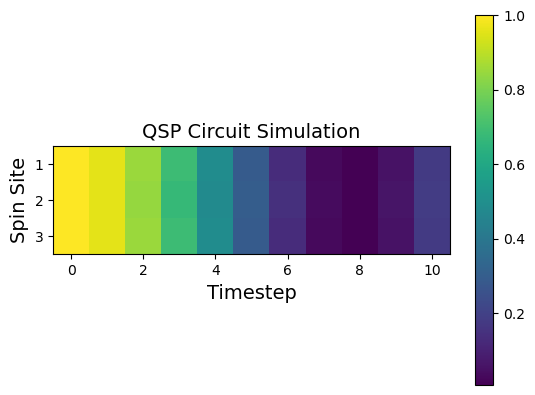

In [18]:

aspect  = 1.0

plt.imshow(np.transpose(np.real(obs_circuit)),cmap='viridis', 
           interpolation='nearest', aspect = aspect)
plt.xlabel('Timestep',fontsize=14)
plt.ylabel('Spin Site',fontsize=14)
plt.title('QSP Circuit Simulation',fontsize=14)

plt.yticks(range(N),range(1,N+1))

plt.colorbar()

plt.show()


We can make a quantitative comparison, and satisfy ourselves that there is good agreement with the classical result:

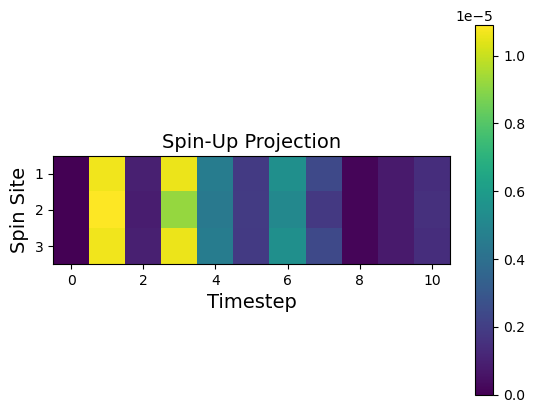

In [20]:

sim_diff = np.abs(obs_circuit - obs_reference)

aspect  = 1.0

plt.imshow(np.transpose(sim_diff),cmap='viridis', interpolation='nearest', 
           aspect=aspect)
plt.xlabel('Timestep',fontsize=14)
plt.ylabel('Spin Site',fontsize=14)
plt.title('Spin-Up Projection',fontsize=14)
plt.yticks(range(N),range(1,N+1))
plt.colorbar()
plt.show()

